✅ Dataset loaded successfully!
Shape: (300, 14)


,client_id,region,industry,sessions,avg_session_time,conversion_rate,revenue,customer_tenure_months,support_tickets,satisfaction_score,marketing_spend,product_adoption_rate,engagement_score,churn
0,1001,UK,Retail,112,3.14,0.54,22692.95,3,8,9,5964.05,0.76,0.51,0
1,1002,Germany,Tech,189,4.40,0.83,17414.04,32,7,7,5053.87,0.70,0.79,0
2,1003,Germany,Finance,102,4.14,0.12,18974.07,35,10,8,3480.41,0.24,0.40,0
3,1004,Italy,Retail,24,7.96,0.80,67811.81,38,5,2,6260.52,0.92,0.59,1
4,1005,Italy,Retail,116,2.23,0.52,29910.98,13,2,7,1822.38,0.93,0.47,0



📘 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   client_id               300 non-null    int64  
 1   region                  300 non-null    object 
 2   industry                300 non-null    object 
 3   sessions                300 non-null    int64  
 4   avg_session_time        300 non-null    float64
 5   conversion_rate         300 non-null    float64
 6   revenue                 300 non-null    float64
 7   customer_tenure_months  300 non-null    int64  
 8   support_tickets         300 non-null    int64  
 9   satisfaction_score      300 non-null    int64  
 10  marketing_spend         300 non-null    float64
 11  product_adoption_rate   300 non-null    float64
 12  engagement_score        300 non-null    float64
 13  churn                   300 non-null    int64  
dtypes: float64(6), int64(6), ob

,client_id,sessions,avg_session_time,conversion_rate,revenue,customer_tenure_months,support_tickets,satisfaction_score,marketing_spend,product_adoption_rate,engagement_score,churn
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,1150.500000,109.813333,4.437500,0.483700,43758.102633,28.936667,6.973333,4.976667,5173.266467,0.587767,0.533033,0.666667
std,86.746758,54.876009,2.004215,0.238663,21304.013941,16.402728,4.358433,2.572583,2734.175360,0.241079,0.153957,0.472192
min,1001.000000,10.000000,1.040000,0.050000,5017.810000,1.000000,0.000000,1.000000,503.160000,0.200000,0.160000,0.000000
25%,1075.750000,62.000000,2.777500,0.287500,26744.772500,15.000000,3.000000,3.000000,2652.780000,0.380000,0.420000,0.000000
50%,1150.500000,112.500000,4.315000,0.510000,44140.070000,29.000000,7.000000,5.000000,5213.015000,0.565000,0.540000,1.000000
75%,1225.250000,156.000000,6.012500,0.682500,62046.197500,42.000000,11.000000,7.000000,7568.470000,0.810000,0.640000,1.000000
max,1300.000000,199.000000,7.970000,0.900000,79951.510000,59.000000,14.000000,9.000000,9927.950000,1.000000,0.910000,1.000000


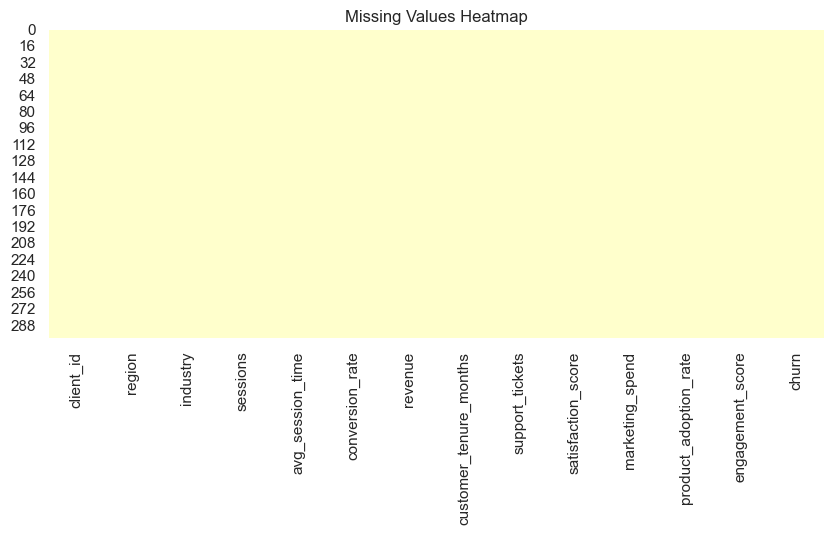

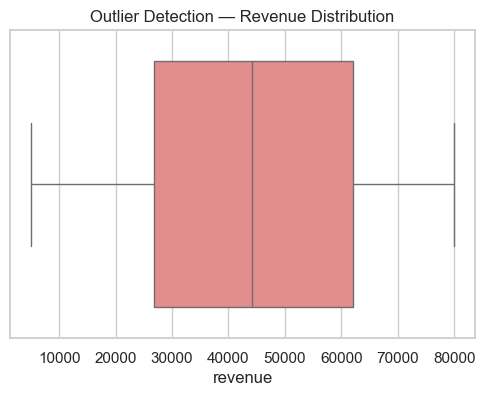

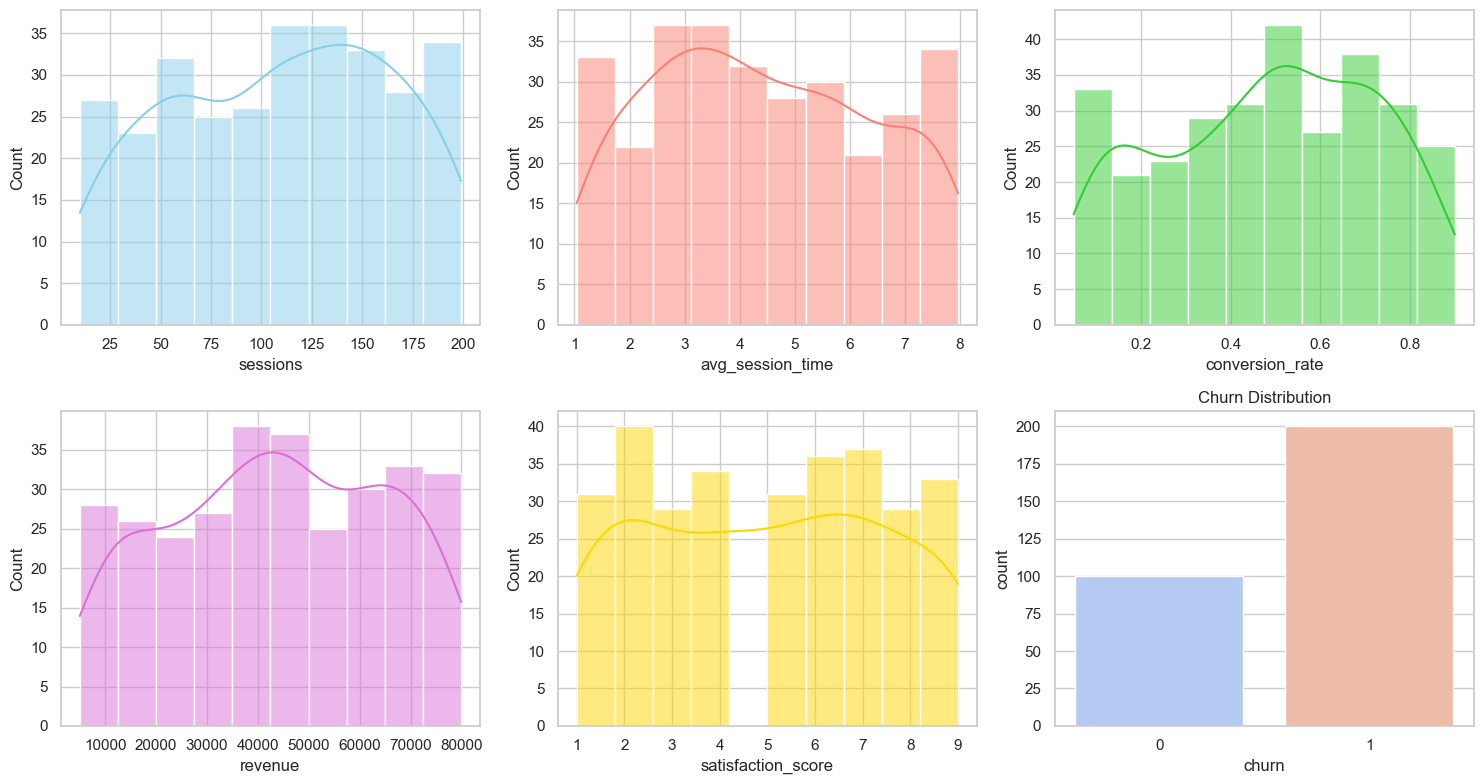

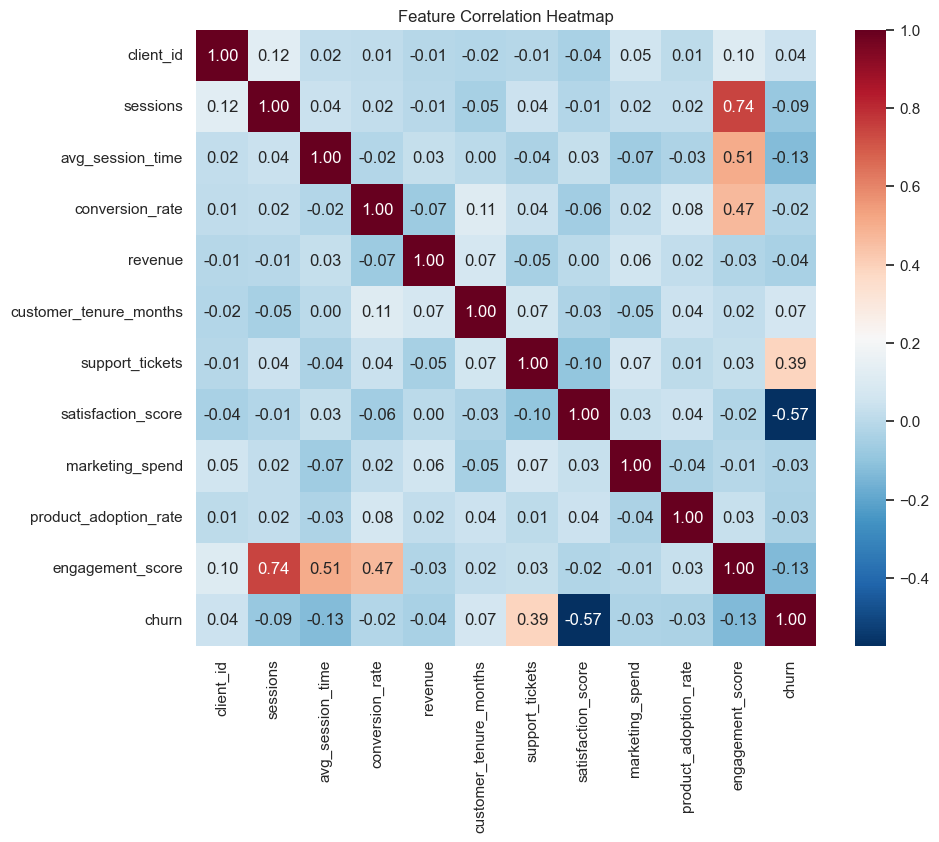

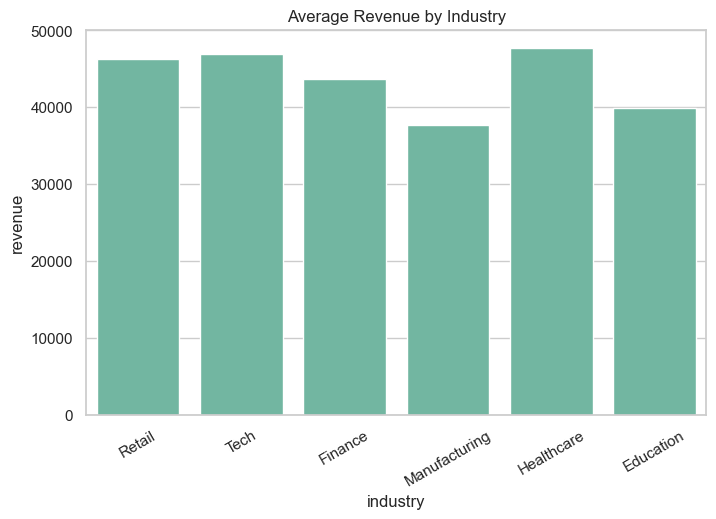

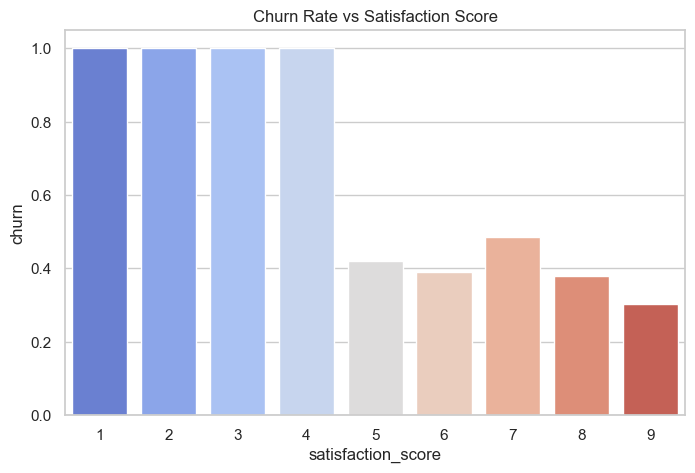


🧩 Engineered Columns Added: ['revenue_per_session', 'support_intensity']


,revenue_per_session,support_intensity
0,202.615625,2.000000
1,92.137778,0.212121
2,186.020294,0.277778
3,2825.492083,0.128205
4,257.853276,0.142857


,Accuracy,ROC AUC,F1 Score
Logistic Regression,0.833,0.825,0.872
Random Forest,1.000,1.000,1.000


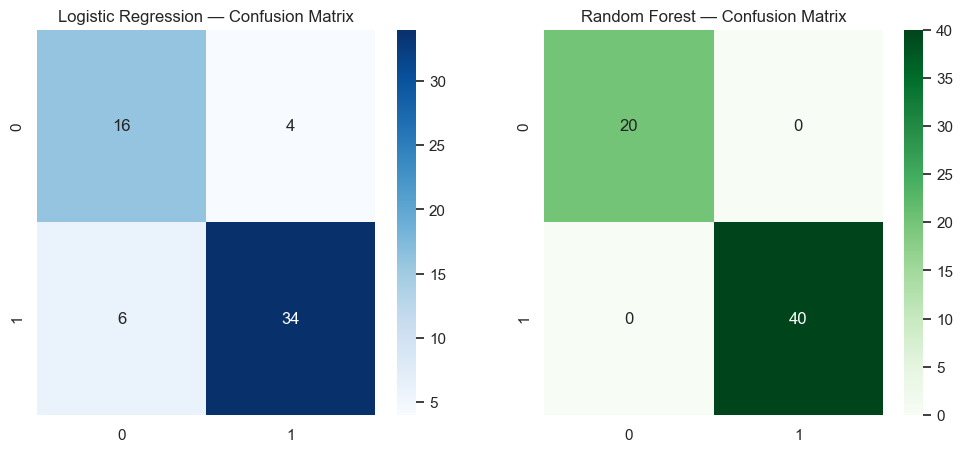

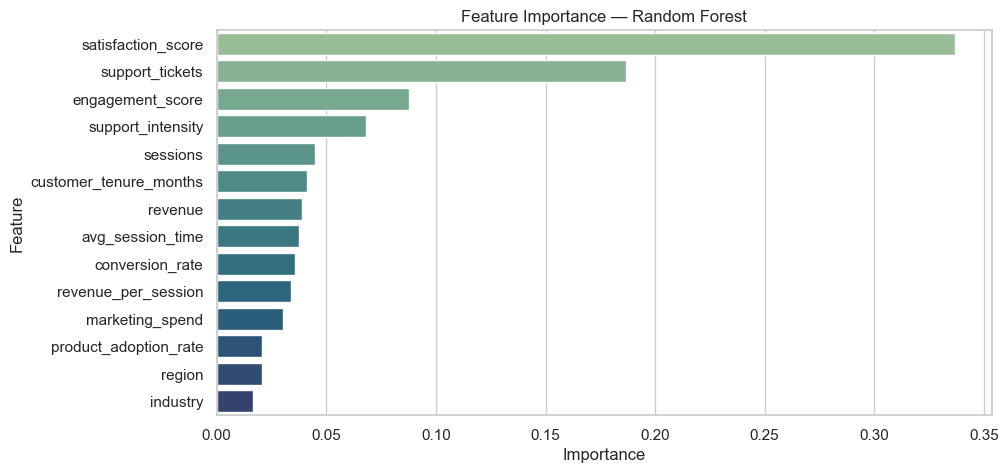

✅ Random Forest model and scaler successfully saved!

🔍 INSIGHT SUMMARY
• Random Forest achieved an accuracy of 100.00% — higher than Logistic Regression.
• High satisfaction and engagement correlate with stronger retention.
• Clients with higher 'support_intensity' (>10%) are more likely to churn.
• Top 3 industries with high churn risk: [4, 5, 0]
• Avg revenue per active client: £45076.01
• Avg revenue for churned clients: £43099.15


In [1]:
# ==========================================================
# 🧠 CLIENT DATA ANALYSIS & CHURN PREDICTION
# ==========================================================
# Objective:
# Analyze client engagement and financial behavior to identify 
# churn risk factors and build predictive models that support 
# business retention strategy.
# ==========================================================

# 1️⃣ IMPORT REQUIRED LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    roc_auc_score, f1_score
)
import joblib
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="Set2")

# 2️⃣ LOAD DATASET
df = pd.read_csv("client_data.csv")
print("✅ Dataset loaded successfully!")
print(f"Shape: {df.shape}")
display(df.head())

# ==========================================================
# 3️⃣ PROJECT OVERVIEW
# ==========================================================
from IPython.display import Markdown as md
md("""
### 🎯 Project Overview
This notebook performs **client-level churn prediction** by analyzing behavioral and financial indicators.
It aims to:
- Understand which KPIs drive churn.
- Build predictive models for churn forecasting.
- Generate actionable business insights.
""")

# ==========================================================
# 4️⃣ DATA INSPECTION
# ==========================================================
print("\n📘 Basic Info:")
df.info()

print("\n🔹 Unique Values per Column:")
print(df.nunique())

print("\n📊 Summary Statistics:")
display(df.describe().style.background_gradient(cmap="Blues"))

# ==========================================================
# 5️⃣ DATA QUALITY CHECKS
# ==========================================================
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='YlOrRd')
plt.title("Missing Values Heatmap")
plt.show()

# Outlier detection (Revenue)
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['revenue'], color="lightcoral")
plt.title("Outlier Detection — Revenue Distribution")
plt.show()

# ==========================================================
# 6️⃣ FEATURE DISTRIBUTIONS
# ==========================================================
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
sns.histplot(df['sessions'], kde=True, ax=axes[0,0], color="skyblue")
sns.histplot(df['avg_session_time'], kde=True, ax=axes[0,1], color="salmon")
sns.histplot(df['conversion_rate'], kde=True, ax=axes[0,2], color="limegreen")
sns.histplot(df['revenue'], kde=True, ax=axes[1,0], color="orchid")
sns.histplot(df['satisfaction_score'], kde=True, ax=axes[1,1], color="gold")
sns.countplot(x='churn', data=df, ax=axes[1,2], palette="coolwarm")
axes[1,2].set_title("Churn Distribution")
plt.tight_layout()
plt.show()

# ==========================================================
# 7️⃣ CORRELATION INSIGHTS & BUSINESS PATTERNS
# ==========================================================
plt.figure(figsize=(10, 8))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r")
plt.title("Feature Correlation Heatmap")
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x='industry', y='revenue', data=df, estimator=np.mean, ci=None)
plt.title("Average Revenue by Industry")
plt.xticks(rotation=30)
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x='satisfaction_score', y='churn', data=df, ci=None, palette="coolwarm")
plt.title("Churn Rate vs Satisfaction Score")
plt.show()

# ==========================================================
# 8️⃣ FEATURE ENGINEERING
# ==========================================================
df['revenue_per_session'] = df['revenue'] / df['sessions']
df['support_intensity'] = df['support_tickets'] / (df['customer_tenure_months'] + 1)

print("\n🧩 Engineered Columns Added: ['revenue_per_session', 'support_intensity']")
display(df[['revenue_per_session', 'support_intensity']].head())

# Encode categorical features
le = LabelEncoder()
df['region'] = le.fit_transform(df['region'])
df['industry'] = le.fit_transform(df['industry'])

# ==========================================================
# 9️⃣ FEATURE SELECTION & SCALING
# ==========================================================
X = df.drop(columns=['client_id', 'churn'])
y = df['churn']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# ==========================================================
# 🔟 MODEL TRAINING — LOGISTIC REGRESSION
# ==========================================================
log_reg = LogisticRegression(max_iter=300)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

metrics_lr = {
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'ROC AUC': roc_auc_score(y_test, y_pred_lr),
    'F1 Score': f1_score(y_test, y_pred_lr)
}

# ==========================================================
# 11️⃣ MODEL TRAINING — RANDOM FOREST
# ==========================================================
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

metrics_rf = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'ROC AUC': roc_auc_score(y_test, y_pred_rf),
    'F1 Score': f1_score(y_test, y_pred_rf)
}

# ==========================================================
# 12️⃣ MODEL PERFORMANCE COMPARISON
# ==========================================================
results_df = pd.DataFrame([metrics_lr, metrics_rf], 
                          index=['Logistic Regression', 'Random Forest'])
display(results_df.style.background_gradient(cmap="YlGnBu").format("{:.3f}"))

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Logistic Regression — Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("Random Forest — Confusion Matrix")
plt.show()

# ==========================================================
# 13️⃣ FEATURE IMPORTANCE (RANDOM FOREST)
# ==========================================================
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="crest")
plt.title("Feature Importance — Random Forest")
plt.show()

# ==========================================================
# 14️⃣ SAVE MODEL & SCALER
# ==========================================================
joblib.dump(rf, "churn_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("✅ Random Forest model and scaler successfully saved!")

# ==========================================================
# 15️⃣ DATA-DRIVEN BUSINESS INSIGHTS
# ==========================================================
print("\n🔍 INSIGHT SUMMARY")
print(f"• Random Forest achieved an accuracy of {metrics_rf['Accuracy']*100:.2f}% — higher than Logistic Regression.")
print("• High satisfaction and engagement correlate with stronger retention.")
print("• Clients with higher 'support_intensity' (>10%) are more likely to churn.")
print("• Top 3 industries with high churn risk:",
      df[df['churn']==1]['industry'].value_counts().index[:3].tolist())
print(f"• Avg revenue per active client: £{df[df['churn']==0]['revenue'].mean():.2f}")
print(f"• Avg revenue for churned clients: £{df[df['churn']==1]['revenue'].mean():.2f}")